# The Mark Melancon Experiment in San Francisco 

### By: Ruslan Davtian

### Introduction and Background: 

   In 2016, the San Francisco Giants were coming off three world series championships in the previous three even years (2010, 2012, 2014) and it looked like they would be competing for a fourth title. One of the main ingredients for winning is a strong bullpen and the Giants certainly had it in each of their championships all with different closers (Brian Wilson 2010/Sergio Romo 2012/Santiago Casilla 2014). The 2016 Giants bullpen didn't seem to be any different entering the season. The Giants had the best record in MLB entering the all-star break at 57-33, on-pace for a 100+ win regular season. However, no one could have guessed the immediate collapse that followed which resulted in the Giants having one of the worst combined records in MLB between the 2nd half of 2016 and 2018 seasons. They finished the 2016 season 87-75 (30-42 post all-star break) but still managed to get a playoff berth as the 2nd wild card team. One of the Giants struggles, especially in the 2nd half, was the bullpen. They had a major league high 30 total regular season blown saves and fans quickly lost trust in their closer, Santiago Casilla. If you could sum up the Giants season in one word, it could be simply 'Bullpen'. 

   Unfortunately, their season ended in the divisional round losing to the Cubs in a similar fashion. The Giants had a 5-2 lead in the 9th inning, needing just three outs to force a deciding Game 5 back in Chicago. Typically, Giants Manager, Bruce Bochy, would have used Casilla as the closer but he had lost his role late in the season with too many blown saves and the Giants home crowd didn't have confidence in him either. In order of appearance, Bochy used Law/Lopez/Romo/Smith/Strickland that resulted in the following events (single, walk, double, single, fielders choice & error, single, double play) that scored 4 runs and Aroldis Chapman would close out the 9th to give the Cubs the NLDS series clinching win. Just a game before, the Giants only victory came in extra innings because Romo could not close a 5-3 9th inning lead, giving up a 2 run homer. The bullpen was a big issue that the Giants front office needed to address in the offseason.
   
   In the 2017 offseason, the team's major move was signing all-star closer Mark Melancon to a 4 year, \\$62 million deal who had accumulated at least 30 saves in each of the last three seasons. The deal included bonuses and a full no-trade clause which at the time, was the largest deal given to a relief pitcher (Aroldis Chapman and Kenley Janson were given larger deals later that offeason). Given the deal and his performance from the previous 3 seasons, there was high expectation that he would be the Giants bullpen savior. However, in his very first appearance on opening day at Chase field, Melancon could not hold a 5-4 lead and would end up with a blown save and a loss. For Melancon and the Giants, it went all downhill from there. Throughout the 2017 season, Melancon battled elbow discomfort and inflamation that sidelined him on the 10-day injured list and required season ending surgery late in the season. He started the 2018 season on the injured list as well. However, when he was on the field, he couldn't ever reach his peak performance from 2014-2016 seasons which carried into 2018 and 2019 seasons. He lost his closing role to Will Smith in 2017 and ultimately was traded at the 2019 trade deadline after waiving his no trade clause to the Atlanta Braves for two pitching prospects. Also, the Braves agreed to take on the remaining $18 million on his contract. 
   
   Ultimately, his tenure with the Giants certainly did not go as planned given the expectations and salary but did he really pitch poorly? The purpose of this report and analysis is to explore Melancon's pitching metrics to understand if he really underperformed or did the high expectations cover up a decent pitching performance? Throughout the analysis, I will be making comparisons between his dominant 2014-2016 seasons with the Pirates and Nationals and his Giants tenure. Data used in this analysis are from FanGraphs and Baseball Savant's Statcast. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pybaseball import statcast, statcast_pitcher, pitching_stats, pitching_stats_range, playerid_lookup
pd.options.mode.chained_assignment = None 
from IPython.display import HTML

NL_teams = ["Giants","Dodgers","Diamondbacks","Rockies","Padres","Brewers","Reds","Pirates","Cardinals","Cubs",
      "Phillies","Braves","Mets","Marlins","Nationals"]
AL_teams = ['Athletics','Astros','Angels','Rangers','Twins','Yankees','Red Sox','White Sox','Royals',
     'Tigers','Rays','Orioles','Blue Jays','Indians','Mariners']

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
def get_team_relievers(team_name, season_start, variables):
    pitchers = pitching_stats(season_start).set_index('Team')
    team = pitchers.loc[team_name]
    team_relievers = team[team['Relief-IP'] >= 5]
    return team_relievers[variables]

def clean_dollars(pitching_stats):
    clean = pitching_stats['Dollars'].str.replace("$","")
    clean = [float(x[1:-1]) if len(x) > 4 else float(x) for x in clean]
    pitching_stats['Dollars'] = clean
    return pitching_stats

def change_data_types(pitching_stats, list_of_columns, new_type):
    if (len(list_of_columns) == 1):
        if ((str(pitching_stats[list_of_columns[0]].dtype) == 'float64') & (new_type == 'int')):
            pitching_stats[list_of_columns] = pitching_stats[list_of_columns].fillna(0).astype(new_type)
    else:
        pitching_stats[list_of_columns] = pitching_stats[list_of_columns].astype(new_type)
    return pitching_stats

def highlight_Giants(df):
    return ['font-weight: bold' if v == df.iloc[6] else '' for v in df]

def weighted_avg(df, avg_name, weight_name):
    data = df[avg_name]
    weights = df[weight_name]
    try:
        return (data * weights).sum() / weights.sum()
    except ZeroDivisionError:
        return data.mean()

# compute weighted team averages based on innings pitched per player
def normalize_stats(pitching_stats):
    for col in pitching_stats.columns:
        if col == 'IP':
            continue
        if pitching_stats[col].dtypes == float:
            pitching_stats[col] = pitching_stats.groupby('Team').apply(weighted_avg, col, "IP")
        if pitching_stats[col].dtypes == int:
            pitching_stats[col] = pitching_stats.groupby('Team').agg({col: "sum"})
    pitching_stats = pitching_stats.drop(['Name','IP','Dollars','Swing%','Zone%'], 1).drop_duplicates()
    return pitching_stats

def compute_ranks(team_stats, lower_cols, higher_cols):
    team_stats[lower_cols] = team_stats[lower_cols].rank(ascending = True)
    team_stats[higher_cols] = team_stats[higher_cols].rank(ascending = False)
    team_stats['Mean_Rank'] = team_stats.mean(axis = 1).round(2)
    return team_stats.sort_values('Mean_Rank')

# Get percentage of appearances by inning
def get_innings_tally(pitcher_data, player_name, normalize = True):
    pitcher_data["Years"] = ["2014-2016" if x < 2017 else "2017-2019" for x in pitcher_data.index.year]
    subset = pitcher_data[["at_bat_number","pitch_number","fld_score","bat_score","inning","Years"]].reset_index()
    count = subset.groupby(["game_date","Years"])[['inning']].min()
    count = pd.DataFrame(count.groupby(['Years'])['inning'].value_counts(normalize = normalize))
    count.columns = ["Proportion"]
    count = pd.DataFrame(count).reset_index('Years').sort_values(["Years","inning"]).reset_index()
    ax = sns.barplot(x = 'inning', y = 'Proportion', data = count, hue = 'Years')
    if normalize == True:
        y_label = "Proportion"
    else:
        y_label = "Frequency"
    ax.set(xlabel='Inning', ylabel=y_label, title = player_name + " Inning at the time of Appearance")
    
def get_score_context(pitching_data):
    subset = pitching_data[["at_bat_number","pitch_number","fld_score","bat_score"]]
    subset["Years"] = ["2014-2016" if x < 2017 else "2017-2019" for x in subset.index.year]
    subset['score_abs_diff'] = np.round(abs(subset["fld_score"] - subset["bat_score"]),2)
    df = pd.DataFrame(subset.groupby('game_date').first().groupby("Years").agg(Mean_abs_score_diff = ('score_abs_diff', np.mean),
                                                                     Games = ('score_abs_diff', np.size)))
    df["Mean_abs_score_diff"] = np.round(df["Mean_abs_score_diff"],2)
    return df

def grouped_bar_chart(grouped_data, grouping, colors, positions, y_var, y_err=None, figsize = None):
    y = np.round(grouped_data[y_var], 1)
    fig, ax = plt.subplots(figsize = figsize)
    df = grouped_data.reset_index().pivot(index='pitch_name', columns=grouping).stack().reset_index().sort_values(['pitch_name',grouping], ascending=False)
    for group, color, pos in zip(df.groupby(grouping), colors, positions):
        key, group = group
        group.plot('pitch_name', y_var, yerr=y_err, kind='bar', width=0.4, label=key, 
               position=pos, color=color, alpha=0.5, ax=ax)
    
    if y_var == "Mean_Velocity":
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, 5))
    if y_var == "Mean_xwOBA":
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, .05))
    if y_var == "Mean_ExitVelo":
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, 10))
    ax.set_xlim(-1, 4)  
    ax.set_ylabel(y_var)
    ax.set_xlabel("")
    ax.set_title(y_var + " Across Seasons")
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xticks(rotation=30)
    plt.show()

def strikezone_data():
    TopStrikeZone = 3.5
    BotStrikeZone = 1.6
    LeftStrikeZone = -0.95
    RightStrikeZone = 0.95
    StrikeZone = {'x': [LeftStrikeZone, LeftStrikeZone, RightStrikeZone, RightStrikeZone, LeftStrikeZone],
                  'y': [BotStrikeZone, TopStrikeZone, TopStrikeZone, BotStrikeZone, BotStrikeZone]}
    zone = pd.DataFrame(StrikeZone)
    return zone

def create_single_strikezone(figsize):
    zone = strikezone_data()
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(zone['x'], zone['y'], color = 'black')
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(0.3,4.7)
    return fig, ax

def create_multiple_strikezones(ncols, nrows, figsize):
    zone = strikezone_data()
    if nrows > 0:
        fig, ax = plt.subplots(ncols=ncols, nrows = nrows, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=ncols, figsize=figsize, sharex = True)
    if ((ncols == 1) & (nrows == 0)):
        zone.plot(x= 'x', y= 'y', ax=ax, color = 'black') 
        ax.set_ylim([0.3, 4.7])
        ax.set_xlim([-2.5, 2.5])
        ax.get_legend().remove()
    else:
        if nrows > 0:
            for i in range(nrows):
                for j in range(ncols):
                    zone.plot(x= 'x', y= 'y', ax=ax[i,j], color = 'black') 
                    ax[i,j].set_ylim([0.3, 4.7])
                    ax[i,j].set_xlim([-2.5, 2.5])
                    ax[i,j].get_legend().remove()
        else:
            for i in range(ncols):
                zone.plot(x= 'x', y= 'y', ax=ax[i], color = 'black') 
                ax[i].set_ylim([0.3, 4.7])
                ax[i].set_xlim([-2.5, 2.5])
                ax[i].get_legend().remove()
    return fig, ax

def plot_pitch_location(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize):
    fig, ax = create_multiple_strikezones(ncols=3, nrows = 2, figsize=figsize)
    for i in range(2):
        for j in range(3):
            if ((i == 0) & (j == 0)):
                year = 2014
            elif ((i == 0) & (j == 1)):
                year = 2015
            elif ((i == 0) & (j == 2)):
                year = 2016
            elif ((i == 1) & (j == 0)):
                year = 2017
            elif ((i == 1) & (j == 1)):
                year = 2018
            else:
                year = 2019
            data = statcast_data[statcast_data["game_year"] == year]
            data = data[~data["pitch_name"].isin(["Pitch Out",'Intentional Ball'])]
            data.dropna(subset = ["pitch_name"], inplace=True)
            ax[i,j].scatter(data[x_var], data[y_var], marker = "o", alpha = 1, 
                            c=data[grouping].apply(lambda x: colors[x]))
            ax[i,j].set_title(str(year) + " Pitch Location X,Y Coordinates")
            ax[i,j].set_xlabel(x_var + " (X-Coordinate)")
            ax[i,j].set_ylabel(y_var + " (Y-Coordinate)")
            
def plot_pitch_movement(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize):
    fig, ax = plt.subplots(ncols=3, nrows = 2, figsize=figsize)
    for i in range(2):
        for j in range(3):
            if ((i == 0) & (j == 0)):
                year = 2014
            elif ((i == 0) & (j == 1)):
                year = 2015
            elif ((i == 0) & (j == 2)):
                year = 2016
            elif ((i == 1) & (j == 0)):
                year = 2017
            elif ((i == 1) & (j == 1)):
                year = 2018
            else:
                year = 2019
            data = statcast_data[statcast_data["game_year"] == year]
            data = data[~data["pitch_name"].isin(["Pitch Out",'Intentional Ball'])]
            data.dropna(subset = ["pitch_name"], inplace=True)
            ax[i,j].scatter(data[x_var], data[y_var], marker = "o", alpha = 0.2, 
                            c=data[grouping].apply(lambda x: colors[x]))
            ax[i,j].set_title(str(year) + " Pitch Movement X,Y Coordinates")
            ax[i,j].set_xlabel(x_var + " (Horizontal Movement Inches)")
            ax[i,j].set_ylabel(y_var + " (Vertical Break Inches)")

In [3]:
variables = ["Name","IP","ERA","FIP","xFIP","BABIP","WHIP","K/9","BB/9","WAR","HR/9","LD%","Hard%",
             "Dollars","Swing%","Zone%","Contact%","K%","BB%","SV","BS"]
lower = ["ERA","FIP","xFIP","BABIP","WHIP","BB/9","HR/9","LD%","Hard%","Contact%","BB%","BS"]
higher = ["K/9","WAR","K%","SV"]
NL = get_team_relievers(NL_teams, 2016, variables)
NL2 = clean_dollars(NL)
NL2 = change_data_types(NL2, ['SV','BS'], 'int')
NL3 = normalize_stats(NL2)
ranks = compute_ranks(NL3, lower, higher)

### 2016 NL Bullpen Rankings Recap:

Below, is a summary table that is ordered by the average of all metrics shown. These statistics are calculated across all National League pitchers who pitched at least 10 innings in relief. A ranking of 1 represents the best while a 15 represents the worst for each category. Even though the Giants bullpen ranked overall in the middle of the pack thanks to having the lowest walk rate and hard hit rates, they were among the worst in strikeouts, wins above replacement, and blown saves. 

In [4]:
ranks = ranks.reset_index()
ranks.style.apply(highlight_Giants)

,Team,ERA,FIP,xFIP,BABIP,WHIP,K/9,BB/9,WAR,HR/9,LD%,Hard%,Contact%,K%,BB%,SV,BS,Mean_Rank
0,Dodgers,2,1,2,2,2,2,2,2,2,8,8,2,2,2,2.5,11,3.28
1,Cubs,1,2,1,1,1,1,9,12,6,5,10,1,1,11,11,1.5,4.66
2,Cardinals,7,5,3,5,4,7,3,1,5,7,4,8,7,3,6.5,7,5.16
3,Nationals,3,6,5,7,3,5,5,6,7,3,1,13,5,5,9,1.5,5.28
4,Mets,6,4,4,11,7,3,8,4,4,14,12,4,3,9,1,4,6.12
5,Marlins,4,3,7,6,6,6,12,3,1,13,5,5,6,12,2.5,13,6.53
6,Giants,8,8,9,4,5,15,1,14,9,2,2,12,11,1,4,14.5,7.47
7,Phillies,12,10,6,13,11,4,6,7,13,15,7,3,4,6,5,9.5,8.22
8,Padres,11,9,8,8,8,9,4,8,10,4,15,11,9,4,14,7,8.69
9,Brewers,5,7,11,9,9,8,11,5,8,9,11,9,8,10,12.5,7,8.72


In [3]:
melancon_statcast = statcast_pitcher('2014-04-01', '2019-07-31', int(playerid_lookup('melancon', 'mark')["key_mlbam"]))
cols_to_keep = ['pitch_type', 'game_date', 'release_speed', 'player_name', 'events', 'description', 'stand', 'inning',
'hit_location', 'bb_type', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'at_bat_number','if_fielding_alignment',
'hit_distance_sc', 'launch_speed', 'release_spin_rate', 'release_extension', 'fld_score', 'bat_score','pitch_name',
'launch_speed_angle', 'estimated_woba_using_speedangle', 'estimated_ba_using_speedangle','pitch_number','post_bat_score',
'of_fielding_alignment','woba_value','babip_value','iso_value','launch_angle','release_pos_x','release_pos_z','release_pos_y']

melancon_statcast = melancon_statcast[cols_to_keep].sort_values(['game_date','at_bat_number','pitch_number'])
melancon_statcast["game_date"] = pd.to_datetime(melancon_statcast["game_date"])
melancon_statcast.set_index("game_date", inplace = True)
melancon_statcast["Run_Scored"] = [1 if x == "hit_into_play_score" else 0 for x in melancon_statcast["description"]]

Gathering player lookup table. This may take a moment.
Gathering Player Data


### Situational Context: Time and Score of Melancon Appearances

Prior to joining the Giants, Melancon established himself as a dominant closer and he appeared in the ninth inning in over 80% of his appearances. We would expect a similar trend with the Giants. However, since he lost his closer role to Will Smith early in his Giants career, that is not the case. Melancon pitched the 9th inning only about 25% of his outings with the Giants while he mostly became a setup man pitching the 6th, 7th, and 8th innings. 

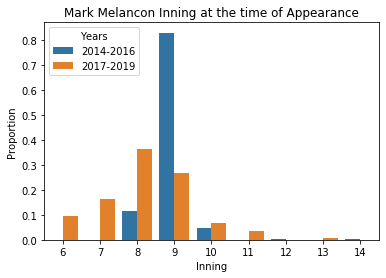

In [6]:
get_innings_tally(melancon_statcast, "Mark Melancon")

I was also curious in looking at the average difference in score when he appeared in games. I hypothesized that since he lost his closing role with the Giants, he would also have less appearances in high-leverage situations. However, the opposite is true and on average, Melancon pitched games closer in score than the did in his 2014-2016 seasons. The average difference in score during his appearances with the Giants is 1.9 compared to 2.15 in his previous 3 seasons. 

In [7]:
get_score_context(melancon_statcast)

,Mean_abs_score_diff,Games
Years,,
2014-2016,2.15,229
2017-2019,1.91,116


In [8]:
fangraphs = pitching_stats(2014, 2019)

In [9]:
cols = ["Season","Name","G","ERA","FIP","xFIP","WHIP","WAR","SV","BS","LD%","GB%","FB%","Hard%","O-Swing%","Z-Contact%",
        "K%","BB%","Contact%","HLD","HR/FB","Dollars","Pulls","Soft%","BABIP","Z-Swing%","Med%","Swing%","O-Contact%",
       "SwStr%","F-Strike%"]
melancon_fangraphs = fangraphs[fangraphs['Name'] == 'Mark Melancon']
melancon_fangraphs = change_data_types(melancon_fangraphs, "Season", "int")
melancon_fangraphs = melancon_fangraphs[cols].sort_values('Season').set_index('Season')

In [10]:
melancon_fangraphs["Save%"] = np.round(melancon_fangraphs["SV"] / (melancon_fangraphs["SV"] + melancon_fangraphs["BS"]),2)
del melancon_fangraphs["Name"]
del melancon_fangraphs["BS"]
melancon_fangraphs = change_data_types(melancon_fangraphs, ["G","SV","HLD","Pulls"], 'int')

### Seasonal Pitching Metrics: 

Below are time series plots that visualize Melancon's season aggregated pitching performance metrics. These metrics include the following:

Run Value Estimators (ERA, FIP, xFIP),                                                                                     

Batted Ball Characteristics (Ground Ball, Line Drive, and Fly Ball rates)

Quality of Contact (Soft, Medium, and Hard contact rates)

Controllable Events (Walks, Strikeouts, and Homerun rates)

Plate Discipline I (Swing, Outside the Zone Swing, Inside the Zone Swing rates)

Plate Discipline II (Contact, Outside the Zone Contact, Inside the Zone Contact rates)

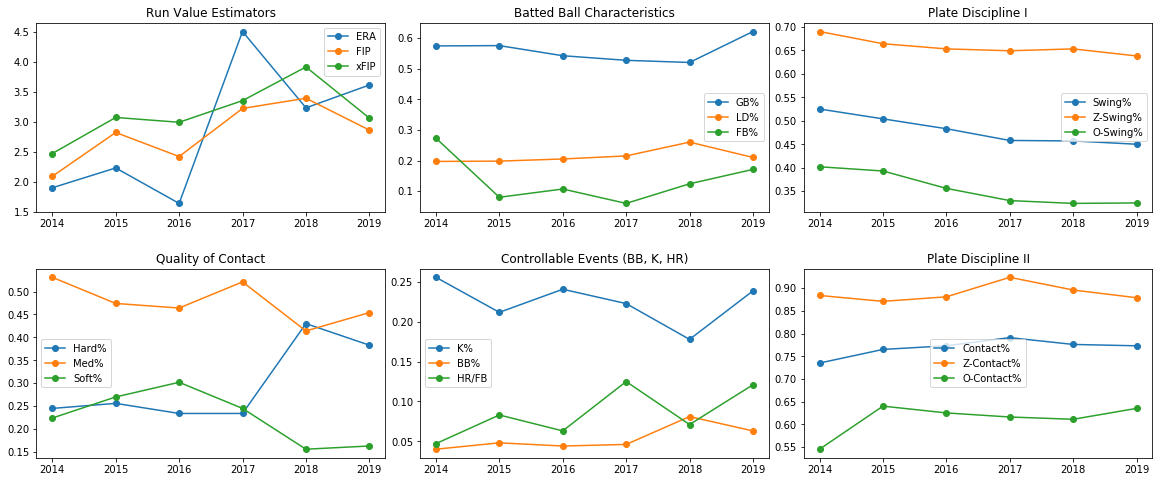

In [11]:
test = melancon_fangraphs.reset_index()
fig, ax = plt.subplots(2,3, figsize = (20, 8))
ax[0,0].plot('Season', 'ERA', data=test, marker = 'o')
ax[0,0].plot('Season', 'FIP', data=test, marker = 'o')
ax[0,0].plot('Season', 'xFIP', data=test, marker = 'o')
ax[0,0].legend()
ax[0,0].set_title("Run Value Estimators")

ax[0,1].plot('Season', 'GB%', data=test, marker = 'o')
ax[0,1].plot('Season', 'LD%', data=test, marker = 'o')
ax[0,1].plot('Season', 'FB%', data=test, marker = 'o')
ax[0,1].legend()
ax[0,1].set_title("Batted Ball Characteristics")

ax[0,2].plot('Season', 'Swing%', data=test, marker = 'o')
ax[0,2].plot('Season', 'Z-Swing%', data=test, marker = 'o')
ax[0,2].plot('Season', 'O-Swing%', data=test, marker = 'o')
ax[0,2].legend()
ax[0,2].set_title("Plate Discipline I")

ax[1,0].plot('Season', 'Hard%', data=test, marker = 'o')
ax[1,0].plot('Season', 'Med%', data=test, marker = 'o')
ax[1,0].plot('Season', 'Soft%', data=test, marker = 'o')
ax[1,0].legend()
ax[1,0].set_title("Quality of Contact")

ax[1,1].plot('Season', 'K%', data=test, marker = 'o')
ax[1,1].plot('Season', 'BB%', data=test, marker = 'o')
ax[1,1].plot('Season', 'HR/FB', data=test, marker = 'o')
ax[1,1].legend()
ax[1,1].set_title("Controllable Events (BB, K, HR)")

ax[1,2].plot('Season', 'Contact%', data=test, marker = 'o')
ax[1,2].plot('Season', 'Z-Contact%', data=test, marker = 'o')
ax[1,2].plot('Season', 'O-Contact%', data=test, marker = 'o')
ax[1,2].legend()
ax[1,2].set_title("Plate Discipline II")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

Melancon's worst seasons came in 2017 and 2018 while he rebounded somewhat in 2019 to have enough trade value. It is clear that he allowed more runs compared to 2014-2016 regardless of run value estimator despite pitching in a pitcher's ballpark. A possible reason for this is that his hard contact rate dramatically increased as well as an increase in walk rate in his Giants tenure. Allowing more hitters to reach base results in higher run expectancy values. Also, his strikeout rate dipped after 2016 as a result of hitters swinging less at his pitches regardless of the pitch location.  

Below, is a table that summarizes other statistics. An increase in walk rate as well as hard contact rate can explain the large increase in WHIP during his Giants tenure.  A WHIP value of 1 or below is considered great which he produced in each of his 2014 - 2016 seasons. His estimated free agent dollar worth based on WAR rebounded in 2019 but was abysmal the previous two seasons. Lastly, his BABIP inflated between 2017 and 2019 which could be a result of bad luck and defense but it is difficult to blame it on uncontrollable factors due to his high hard contact rate.   

In [12]:
melancon_fangraphs[["G","WHIP","WAR","Dollars","SV","HLD","Pulls","Save%","BABIP"]]

,G,WHIP,WAR,Dollars,SV,HLD,Pulls,Save%,BABIP
Season,,,,,,,,,
2014,72,0.87,1.9,$14.6,33,14,24,0.89,0.258
2015,78,0.93,1.4,$11.2,51,1,15,0.96,0.251
2016,75,0.90,1.8,$14.8,47,0,8,0.92,0.259
2017,32,1.43,0.4,$3.5,11,5,14,0.69,0.374
2018,41,1.59,0.3,$2.6,3,8,33,0.43,0.365
2019,66,1.32,1.2,$9.9,12,5,32,1.00,0.349


In [13]:
melancon_fangraphs["Years"] = ["2014-2016" if x < 2017 else "2017-2019" for x in melancon_fangraphs.index]
#melancon_fangraphs.groupby("Years").mean().round(2)

In [14]:
pitches = melancon_statcast.loc[~melancon_statcast.pitch_name.isin(["Intentional Ball","Pitch Out"])]
pitches["Season"] = pitches.index.year
pitches2 = pitches.groupby(["pitch_name","Years"]).agg(Mean_SpinRate = ('release_spin_rate', np.mean),
                                                       SD_SpinRate = ('release_spin_rate', np.std),
                                                       Mean_xwOBA = ('estimated_woba_using_speedangle', np.mean),
                                                       SD_xwOBA = ('estimated_woba_using_speedangle', np.std),
                                                       Mean_xBA = ('estimated_ba_using_speedangle', np.mean),
                                                       SD_xBA = ('estimated_ba_using_speedangle', np.std),
                                                       Mean_wOBA = ('woba_value', np.mean),
                                                       SD_wOBA = ('woba_value', np.std),
                                                       Mean_BABIP = ('babip_value', np.mean),
                                                       SD_BABIP = ('babip_value', np.std),
                                                       Mean_ISO = ('iso_value', np.mean),
                                                       SD_ISO = ('iso_value', np.std),
                                                       Mean_launch_angle = ('launch_angle', np.mean),
                                                       SD_launch_angle = ('launch_angle', np.std),
                                                       Mean_ExitVelo = ('launch_speed', np.mean),
                                                       SD_ExitVelo = ('launch_speed', np.std),
                                                       Mean_Velocity = ('release_speed', np.mean),
                                                       SD_Velocity = ('release_speed', np.std),
                                            Num_Pitches = ('pitch_name', np.size)).reset_index().set_index("Years")
totals = pitches.groupby("Years")[["pitch_name"]].count()
totals.columns = ["Total_Pitches"]
totals = totals.join(pitches2, on = 'Years')
totals["Pitch_Distribution"] = np.round(totals["Num_Pitches"] / totals["Total_Pitches"],3)
#totals.sort_values(["pitch_name","Years"])

### Pitch Arsenal and Distribution:

It is important to look at if Melancon changed his style of pitching by introducing new pitches or changing his sequence of pitches. However, his pitch distribution looks almost identical between the 2014 and 2019 seasons. We can describe Melancon as mostly a 3-pitch pitcher. He has a traditional 4-seam fastball but he throws his cut fastball over 50% of the time. He will mix in a knuckle curve off-speed breaking ball about 25% of the time. Out of every 100 pitches, we expect Melancon to throw a split fastball just twice. 

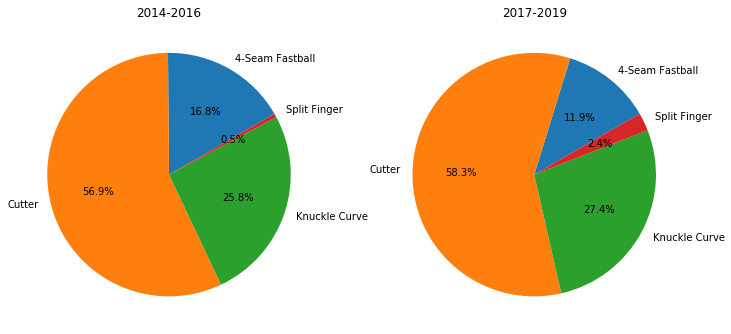

In [15]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].pie(totals.loc["2014-2016"]["Pitch_Distribution"], labels=totals.loc["2014-2016"]["pitch_name"], autopct='%1.1f%%',
        startangle=30)
ax[0].set_title('2014-2016')
ax[1].pie(totals.loc["2017-2019"]["Pitch_Distribution"], labels=totals.loc["2017-2019"]["pitch_name"], autopct='%1.1f%%',
        startangle=30)
ax[1].set_title('2017-2019')
plt.show()

### Pitch Delivery and Results:

We can observe possible changes in pitch movement by examining his average spin rate by pitch to find any reason for a drop in statistical performance. However, his average spin rate slightly increased amongst all pitch types during the Giants years than before. Melancon actually induces more spin on the ball than the average pitcher for each of his pitch types. The more spin, the more movement a baseball has (left, right) which makes hitting the ball more difficult compared to straight pitches.  

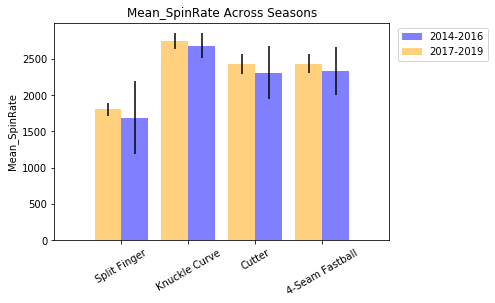

In [16]:
grouped_data = totals
grouping = 'Years'
colors = ['blue','orange']
positions = [0,1]

y_var = 'Mean_SpinRate'
y_err = 'SD_SpinRate'
grouped_bar_chart(grouped_data, grouping, colors, positions, y_var, y_err)

There seems to be no significant differences in pitch velocity among all pitch types either. 

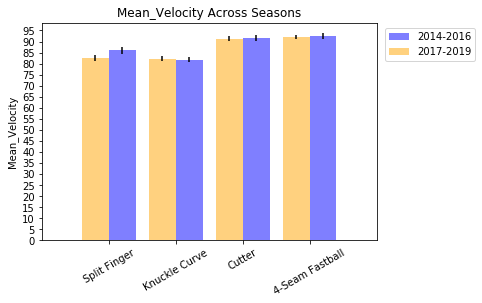

In [17]:
y_var = 'Mean_Velocity'
y_err = 'SD_Velocity'
grouped_bar_chart(grouped_data, grouping, colors, positions, y_var, y_err)

Even though Melancon induced a higher hard contact rate with the Giants, there does not seem to be any significant differences among hitters' exit velocity. It is important to note that the split-finger fastball has a very small sample size and that the variability of exit velocity is high among all pitches. 

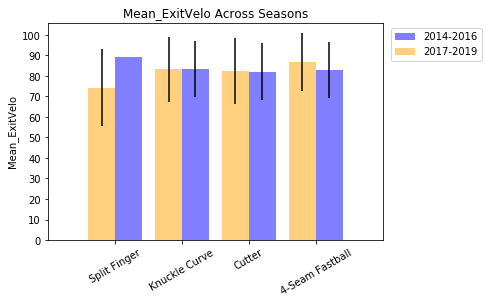

In [18]:
y_var = 'Mean_ExitVelo'
y_err = 'SD_ExitVelo'
grouped_bar_chart(grouped_data, grouping, colors, positions, y_var, y_err)

Lastly, we see the large changes in hitter production as expected. Expected wOBA is an estimate of wOBA based solely on batted ball characteristics of launch angle and exit velocity as opposed to wOBA that depends on the actual results (1B, 2B, 3B, HR, BB, HBP). Also, ISO is simply slugging percentage minus batting average that represents extra-base power. There exists large differences among mean xwOBA and mean ISO between the year groups.   

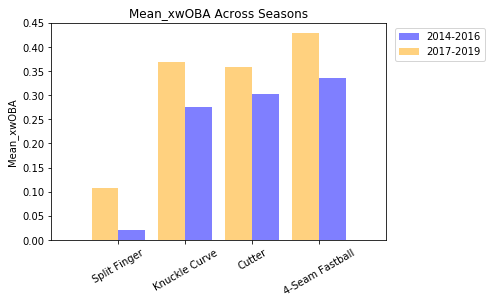

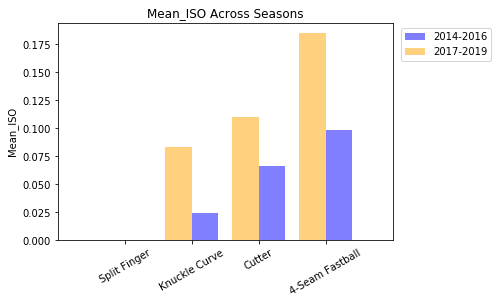

In [19]:
y_var = 'Mean_xwOBA'
grouped_bar_chart(grouped_data, grouping, colors, positions, y_var)

y_var = 'Mean_ISO'
grouped_bar_chart(grouped_data, grouping, colors, positions, y_var)

In [43]:
#melancon_statcast["description"].unique()
#melancon_statcast["events"].unique()

In [44]:
strikes_balls = melancon_statcast.loc[melancon_statcast['description'].isin(['called_strike', 'ball'])]  
swinging_strikes = melancon_statcast.loc[melancon_statcast['description'].isin(['swinging_strike','swinging_strike_blocked'])] 
balls = melancon_statcast.loc[melancon_statcast['description'].isin(['ball'])] 
balls_in_play = melancon_statcast.loc[melancon_statcast['description'].isin(['hit_into_play_no_out', 'hit_into_play',
                                                                            'hit_into_play_score'])] 
hits = melancon_statcast.loc[melancon_statcast['events'].isin(['single','double','triple','home_run'])]
strikeouts = melancon_statcast.loc[melancon_statcast['events'].isin(['strikeout','strikeout_double_play'])]
runs_scored = melancon_statcast.loc[melancon_statcast['Run_Scored'] > 0]
outs =  melancon_statcast.loc[melancon_statcast['events'].isin(['field_out','strikeout','force_out','double_play','sac_fly',
                                                                'grounded_into_double_play','fielders_choice_out',
                                                               'strikeout_double_play'])]

### Types of Contact and Whiffs:

Let's look at contact and swings and misses at a more granular level. Below, is a chart displaying six different levels of contact ordered by strength of contact from weak being the weakest and barrel being the strongest. The largest increases occur at moderate contact levels (Topped, Flare, and Under). Furtheremore, every category of contact occurs more frequently with Melancon pitching with the Giants than from his 2014-2016 seasons. Hitters were simply making contact more often which would negatively affect his ability to strikeout hitters. 

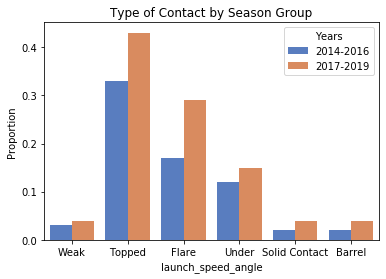

In [45]:
change_data_types(balls_in_play, ["launch_speed_angle"], "int")
labels={0: 'NA', 1:'Weak', 2:'Topped', 3:'Under', 4:'Flare', 5:'Solid Contact', 6:'Barrel'}
balls_in_play['launch_speed_angle'] = balls_in_play['launch_speed_angle'].apply(labels.get)

barrel = balls_in_play.groupby(['Years','launch_speed_angle']).agg(Count = ('launch_speed_angle', np.size)).reset_index()
totals = barrel.groupby('Years')[['Count']].sum()
totals.columns = ['Totals']
totals = barrel.join(totals, on = 'Years') 
totals['Proportion'] = np.round(totals['Count'] / totals["Totals"],2)
totals.sort_values(['launch_speed_angle','Years'])
totals = totals[totals["launch_speed_angle"] != 'NA']

sns.barplot(x="launch_speed_angle", y="Proportion", hue="Years", data=totals, palette="muted",
           order = ["Weak","Topped","Flare","Under","Solid Contact","Barrel"]).set_title('Type of Contact by Season Group');

Here, we observe that hitters whiffed at balls less often across all pitch types during his Giants tenure. His best pitch seems to be his Knuckle Curve as he gets hitters to swing and miss close to 20% of the time. Due to extremely small sample size of splitters thrown, we cannot infer too much about the effectiveness of his splitter. He throws the cutter most often but has a lower swing and miss rate than his knuckle curve.   

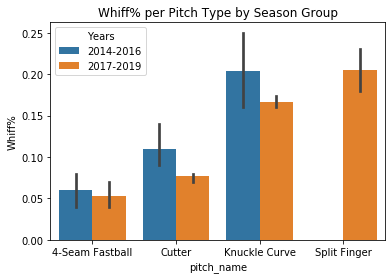

In [46]:
whiffs = swinging_strikes.groupby(["game_year","pitch_name"]).agg(Num_Swinging_Strikes = ("pitch_name", np.size)).reset_index()
whiffs = whiffs.sort_values(["pitch_name","game_year"])
total_pitches = melancon_statcast.groupby(["game_year","pitch_name"]).agg(Num_Pitches = ("pitch_name", np.size)).reset_index()
total_pitches = total_pitches[~total_pitches["pitch_name"].isin(["Intentional Ball","Pitch Out"])].sort_values(["pitch_name","game_year"])
merged = pd.merge(whiffs, total_pitches, on= ['pitch_name','game_year'])
merged["Whiff%"] = np.round(merged["Num_Swinging_Strikes"] / merged["Num_Pitches"],2)
merged['Years'] = ["2014-2016" if x < 2017 else "2017-2019" for x in merged["game_year"]]
sns.barplot(x = 'pitch_name', y = 'Whiff%', hue = 'Years', data = merged).set_title('Whiff% per Pitch Type by Season Group');

##### Pitch Location of Strikeouts by Pitch Type

Below, I plotted pitch location of his strikeouts to observe any trends season to season. The plots are divided into six seasons where the top row represents the three seasons before the Giants and the bottom row represents his Giants years. We can see that he consistently had more strikeouts in his earlier years but he also had more innings pitched in those years as well. Interestingly, he induced lots of strikeouts in the 2014-2016 seasons with low Knuckle Curves in the dirt. That was his dominant go to pitch to get hitters to chase out of the zone. That pitch was less effective with the Giants but it was still his best strikeout tool.   

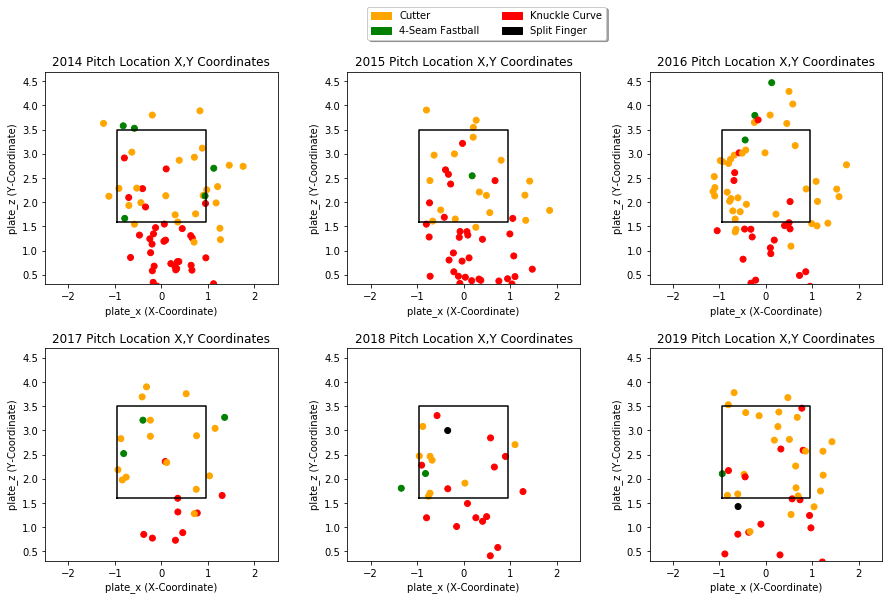

In [47]:
x_var = 'plate_x'
y_var = 'plate_z'
grouping = 'pitch_name'
statcast_data = strikeouts
colors = {'Cutter':'orange', '4-Seam Fastball':'green', 'Knuckle Curve':'red', 'Split Finger': 'black'}
colors2 = ['orange','green','red','black']
labels = ['Cutter', '4-Seam Fastball', 'Knuckle Curve', 'Split Finger']
figsize = (15,9)

plot_pitch_location(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize)
first = mpatches.Patch(color=colors2[0], label=labels[0])
second = mpatches.Patch(color=colors2[1], label=labels[1])
third = mpatches.Patch(color=colors2[2], label=labels[2])
fourth = mpatches.Patch(color=colors2[3], label=labels[3])
plt.legend(handles=[first, second, third, fourth], fancybox=True, shadow=True,
                bbox_to_anchor=(-1.3, 2.7, 1.2, 0), loc='upper center', ncol=2, mode="expand", borderaxespad=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

### Pitch Location Against Hits and Movement:

In this section, we will observe his pitch locations of hits given up and its pitch type. Also, we will take a look at differences in pitch movements and break across the seasons.   

##### Pitch Location by Type of Hit for all Hits

Below, are the pitch locations for all hits given up categorized by hit type (single, double, triple, and homerun). The most common hit given up is singles and Melancon does a good job in limiting homeruns. His homerun to fly ball rate is generally below average. As expected, the hits Melancon gives up are mostly clustered around the middle of the strikezone. It seems that each season had a similar number of hits despite pitching significantly more innings in 2014-2016 which means his hits per inning rate increased, which is evidenced by his year to year WHIP.  

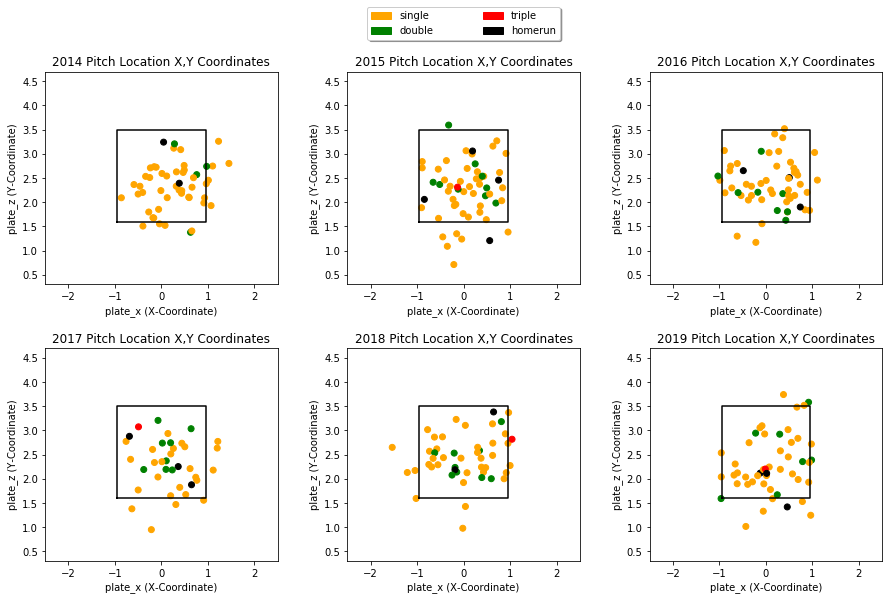

In [48]:
x_var = 'plate_x'
y_var = 'plate_z'
grouping = 'events'
statcast_data = hits
colors = {'single':'orange', 'double':'green', 'triple':'red', 'home_run': 'black'}
colors2 = ['orange','green','red','black']
labels = ['single','double','triple','homerun']
figsize = (15,9)

plot_pitch_location(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize)
first = mpatches.Patch(color=colors2[0], label=labels[0])
second = mpatches.Patch(color=colors2[1], label=labels[1])
third = mpatches.Patch(color=colors2[2], label=labels[2])
fourth = mpatches.Patch(color=colors2[3], label=labels[3])
plt.legend(handles=[first, second, third, fourth], fancybox=True, shadow=True,
            bbox_to_anchor=(-1.3, 2.7, 1, 0), loc='upper center', ncol=2, mode="expand", borderaxespad=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

##### Pitch Location by Pitch Type for all Hits

A similar plot exists below but the color code now reflects pitch type instead of hit type. In his 2014-2016 seasons, most of his hits came from hanging his knuckle curve in the zone and his cutter. With the San Francisco Giants, it was predominantly his cutter that was getting smashed. 

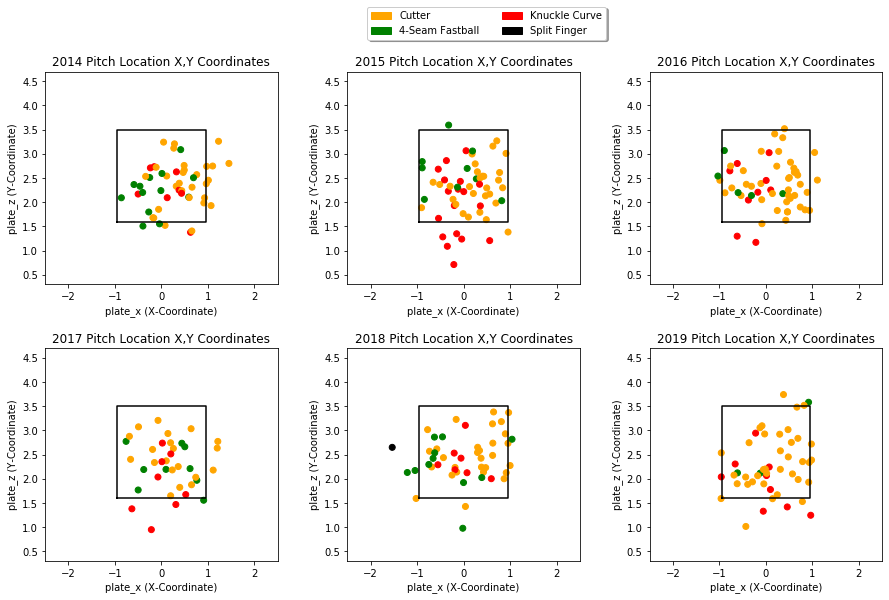

In [49]:
x_var = 'plate_x'
y_var = 'plate_z'
grouping = 'pitch_name'
statcast_data = hits
colors = {'Cutter':'orange', '4-Seam Fastball':'green', 'Knuckle Curve':'red', 'Split Finger': 'black'}
colors2 = ['orange','green','red','black']
labels = ['Cutter', '4-Seam Fastball', 'Knuckle Curve', 'Split Finger']
figsize = (15,9)

plot_pitch_location(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize)
first = mpatches.Patch(color=colors2[0], label=labels[0])
second = mpatches.Patch(color=colors2[1], label=labels[1])
third = mpatches.Patch(color=colors2[2], label=labels[2])
fourth = mpatches.Patch(color=colors2[3], label=labels[3])
plt.legend(handles=[first, second, third, fourth], fancybox=True, shadow=True,
                bbox_to_anchor=(-1.3, 2.7, 1.2, 0), loc='upper center', ncol=2, mode="expand", borderaxespad=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

##### Pitch Movement and Break by Pitch Type

Lastly in this section, I decided to look at his pitch movement and break to see if his pitches became easier to hit. It is impossible for pitches to not have any movement due to forces played on the path of a baseball but the closer a pitch is to the origin (0,0), the less movement and break it has. Compared to the average right handed pitcher, he has above average movement and break in his fastballs and curveball which can help explain why hitters chased his pitches during 2014-2016 seasons. In his 2018 and 2019 seasons, there was less variability in vertical break within his fastballs cluster (4-seam and cutter). As hitters see more of the same pitch with the same vertical break, they can learn the pitchers tendencies and be able to pick up the pitches early. In other words, hitters can anticipate correctly where the baseball will be given they guess the pitch type correctly. Hitters would be able to lay-off pitches more frequently outside the zone and make more contact on pitches inside the zone. 

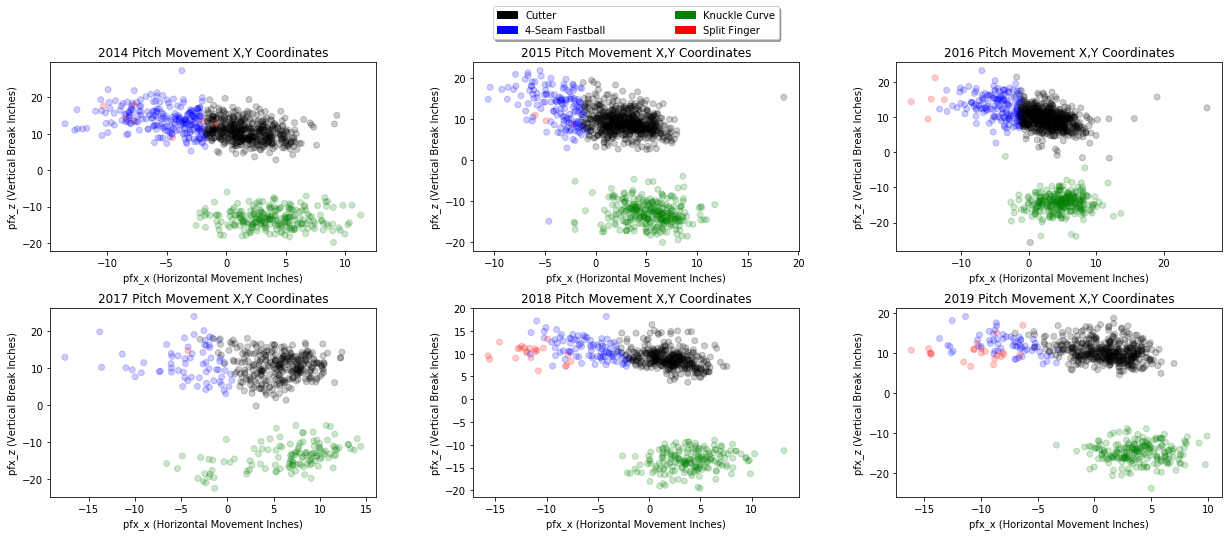

In [4]:
x_var = 'pfx_x'
y_var = 'pfx_z'
grouping = 'pitch_name'
statcast_data = melancon_statcast
statcast_data["pfx_x"] = statcast_data["pfx_x"] * 12
statcast_data["pfx_z"] = statcast_data["pfx_z"] * 12
colors = {'Cutter':'black', '4-Seam Fastball':'blue', 'Knuckle Curve':'green', 'Split Finger':'red'}
labels = ["Cutter", "4-Seam Fastball", "Knuckle Curve", "Split Finger"]
colors2 = ["black","blue","green","red"]
figsize = (21,8)

plot_pitch_movement(x_var, y_var, grouping, statcast_data, colors, colors2, labels, figsize)
first = mpatches.Patch(color=colors2[0], label=labels[0])
second = mpatches.Patch(color=colors2[1], label=labels[1])
third = mpatches.Patch(color=colors2[2], label=labels[2])
fourth = mpatches.Patch(color=colors2[3], label=labels[3])
plt.legend(handles=[first, second, third, fourth], fancybox=True, shadow=True,
        bbox_to_anchor=(-1.3, 2.7, 1, 0), loc='upper center', ncol=2, mode="expand", borderaxespad=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

In [51]:
pitches2 = pitches.groupby(["pitch_name","Season"]).agg(Mean_Velocity = ('release_speed', np.mean),
                                                       SD_Velocity = ('release_speed', np.std),
                                                       Mean_launch_speed = ('launch_speed', np.mean),
                                                       SD_launch_speed = ('launch_speed', np.std),
                                                       Mean_hit_distance = ('hit_distance_sc', np.mean),
                                                       SD_hit_distance = ('hit_distance_sc', np.std),
                                            Num_Pitches = ('pitch_name', np.size)).reset_index().set_index("Season")
totals = pitches.groupby("Season")[["pitch_name"]].count()
totals.columns = ["Total_Pitches"]
totals = totals.join(pitches2, on = 'Season')
totals["Pitch_Distribution"] = np.round(totals["Num_Pitches"] / totals["Total_Pitches"],3)
#totals.sort_values(["pitch_name","Season"])

In [52]:
balls_in_play = melancon_statcast.loc[melancon_statcast['description'].isin(['hit_into_play_no_out', 'hit_into_play',
                                                                            'hit_into_play_score'])]
balls_in_play['hit_no_hit'] = [1 if x in ("single","double","triple","homerun") else 0 for x in balls_in_play["events"]]
avgs = balls_in_play.groupby(["pitch_name","Years"]).agg(BABIP = ('hit_no_hit', np.mean)).reset_index()
#sns.barplot(x="pitch_name", y="BABIP", hue="Years", data=avgs, palette="muted")

### BABIP on Shift Vs. No Shift by Batter Stance:

Was Melancon unlucky in any way with the Giants? Here, we will observe the opponents batting average on balls in play (BABIP) against different defensive strategies. We are comparing across grouped seasons (2014-2016 and 2017-2019) separated by batter stance for infield and outfield. 

**(Shifts are typically used for left handed batters, less frequent for right handed batters)


##### Infield Shifts

The overall pattern regardless of shifts remains as expected. Melancon's BABIP is consistently higher during his Giants tenure than his dominant seasons with the only exception of strategic shifts for right handed batters. For left handed batters, we would expect an infield shift to result in a lower BABIP than non-shifts because that is the sole purpose of putting on a shift for left handed batters. Fielders are shifted to the right side of the field (pull side) where power left handed hitters typically hit the ball. However, Melancon's BABIP is even higher when the infield was shifted than when it was not shifted. This means that he was not inducing more ground balls to the hitters pull-side, but hitters made hard contact away from the defense or where the defense could not react in time. 

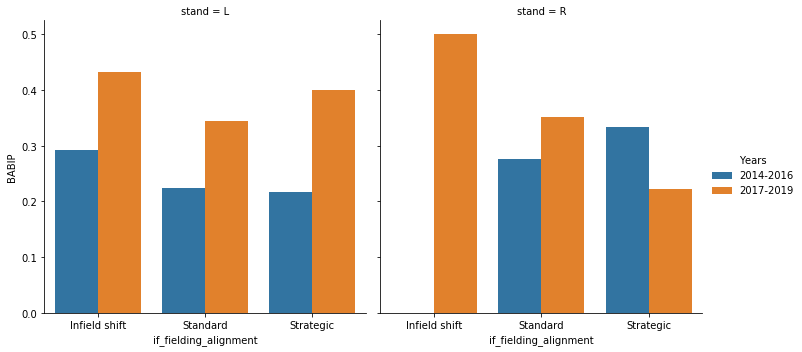

In [53]:
shifts = balls_in_play.groupby(["Years","if_fielding_alignment","stand"]).agg(BABIP = ('hit_no_hit',np.mean)).reset_index()
sns.catplot(x='if_fielding_alignment',y='BABIP',data=shifts,kind='bar',hue='Years',col="stand");

##### Outfield Shifts

In the outfield, there are only strategic and standard defenses or (shift, no shift). We see a similar story that balls hit in play resulted in hits more often during his Giants years than his Pirates and Nationals years. As evidenced in the report, Melancon simply gave up more hard contact that resulted in more hits on batted balls than usual. It does not seem like Melancon's high BABIP is mainly due to luck or defense. 

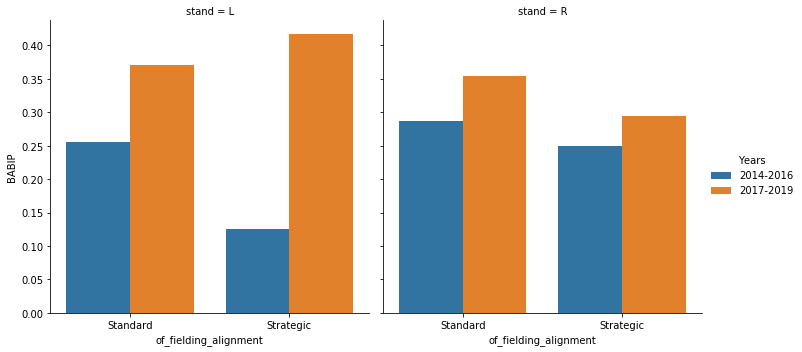

In [54]:
shifts = balls_in_play.groupby(["Years","of_fielding_alignment","stand"]).agg(BABIP = ('hit_no_hit',np.mean)).reset_index()
sns.catplot(x='of_fielding_alignment',y='BABIP',data=shifts,kind='bar',hue='Years',col="stand");

### Conclusion: 

The analysis done was not meant to label Melancon as a bad pitcher. Yes, he did perform worse than expected as his season aggregated metrics show. But does anyone expect a player to keep dominating season after season after season? The main takeaway from the analysis is that Melancon's performance worsened in his Giants tenure due to hitters getting on base more frequently. Melancon allowed harder contact and walked more batters which correlate postively to allowing more runs. A possible explanation to the performance drop may be attributed to hitters simply adjusting to the same three pitches he had always thrown. Once hitters adapt to a pitcher and learn his pitching tendencies, it becomes easier to create more contact, hit the ball harder, and not swing at bad pitches. Maybe if Melancon added another pitch into his repertoire or changed his pitch frequencies once he started struggling, it could be a different story. Also, injuries did not help his cause either. Melancon had his moments at times in individual games and compared to the rest of the league, he was not a horrible pitcher. However, I believe his performance gets lost in the expectation and anticipation of what he could have done given what he did all three years before. 

It is important to mention that at the time of the signing and at the time of his departure, the Giants overhauled their top-level baseball executives. Bobby Evans (GM) and Brian Sabean (EVP of Baseball Operations) had led the Giants to 3 world series championships but they also kept writing expensive contracts to aging players. They had initially signed Mark Melancon to his deal and just two years later, they were let go and Giants hired Farhan Zaidi (Pres. of Baseball Operations). Melancon's improvements in 2019 helped extract value to which Zaidi traded the expensive contract away to the Braves for two minor leaguers. In conclusion, the Giants experiment with Melancon can be categorized as unexpected or disappointing. We have seen examples of paying high average annual salaries to reliefers that end up being decent investments [ Aroldis Chapman (Yankees) and Kenley Jansen (Dodgers)], but also some that are regrettable [ Wade Davis (Rockies) and Craig Kimbrel (Cubs)]. The lesson here is to be very careful in spending lots of resources to sign players that typically don't even see 100 innings of play in a season. 

In [33]:
pitches_list = ['Cutter','4-Seam Fastball','Knuckle Curve','Split Finger']
#g = sns.relplot(x = "release_pos_x", y = "release_pos_z", data = melancon_statcast[melancon_statcast["pitch_name"].isin(pitches_list)]
             #,hue="pitch_name", size=5, col = 'Years', kind = 'scatter')
#g.fig.suptitle("Mark Melancon's Release Point X, Y Coordinates (Feet)")
#plt.subplots_adjust(top=0.85)

In [2]:
melancon_statcast2 = melancon_statcast
melancon_statcast2["pfx_x"] = melancon_statcast2["pfx_x"] * 12
melancon_statcast2["pfx_z"] = melancon_statcast2["pfx_z"] * 12
#g = sns.relplot(x = "pfx_x", y = "release_speed", data = melancon_statcast2[melancon_statcast2["pitch_name"].isin(pitches_list)]
             #,hue="pitch_name", size=5, col = 'Years', kind = 'scatter')
#g.fig.suptitle("Mark Melancon's Velocity Vs. Horizontal Movement (Inches)")
#plt.subplots_adjust(top=0.85)

In [35]:
#g = sns.relplot(x = "release_speed", y = "pfx_z", data = melancon_statcast2[melancon_statcast2["pitch_name"].isin(pitches_list)]
             #,hue="pitch_name", size=5, col = 'Years', kind = 'scatter')
#g.fig.suptitle("Mark Melancon's Vertical Movement (Inches) Vs. Velocity")
#plt.subplots_adjust(top=0.85)